# Compute Rt for Haredim cities (Bnei-Brak, Elad, Modiin-Ilit, Beitar-Ilit)

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-za9zr126 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
dfcit = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False, cities=True)
bb = ['6100', '3780', '3797', '1309', '1137']
model_bb = dfcit.loc[bb].groupby('date').sum()
gmbb = GenerativeModel(bb, model_bb, buffer_days = 10, delay=2, sigma=0.07)
gmbb.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2060 seconds.


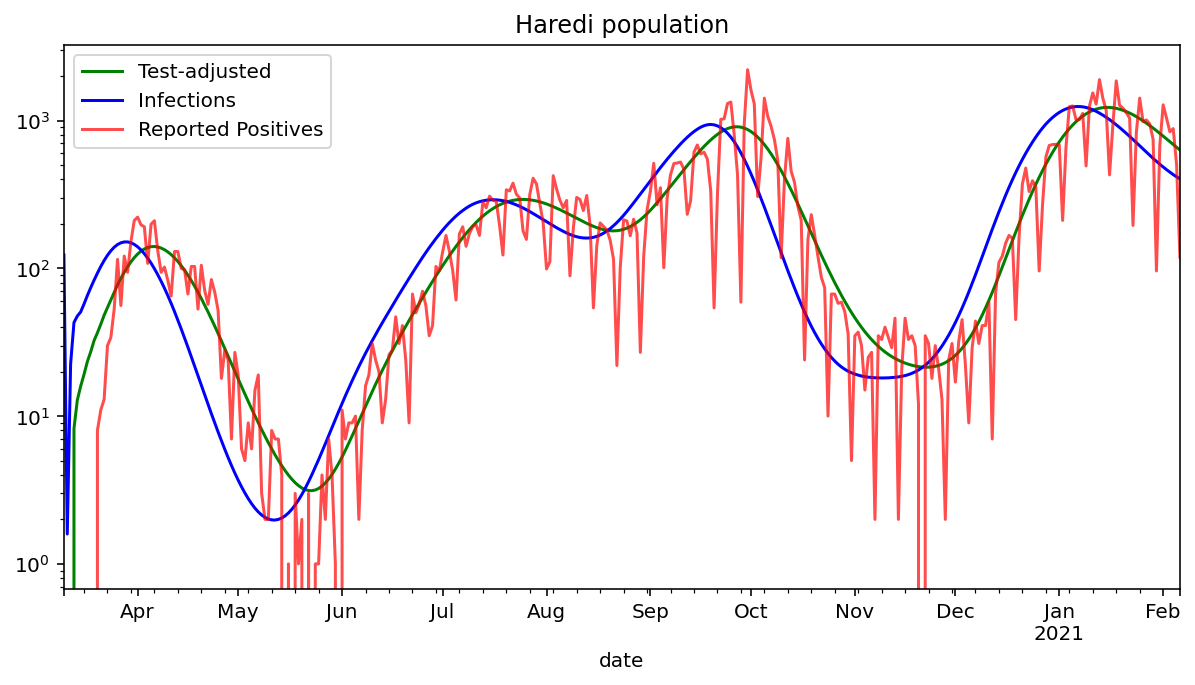

In [3]:
resultbb = summarize_inference_data(gmbb.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Haredi population")
resultbb.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultbb.infections.plot(c="b", label="Infections")
gmbb.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

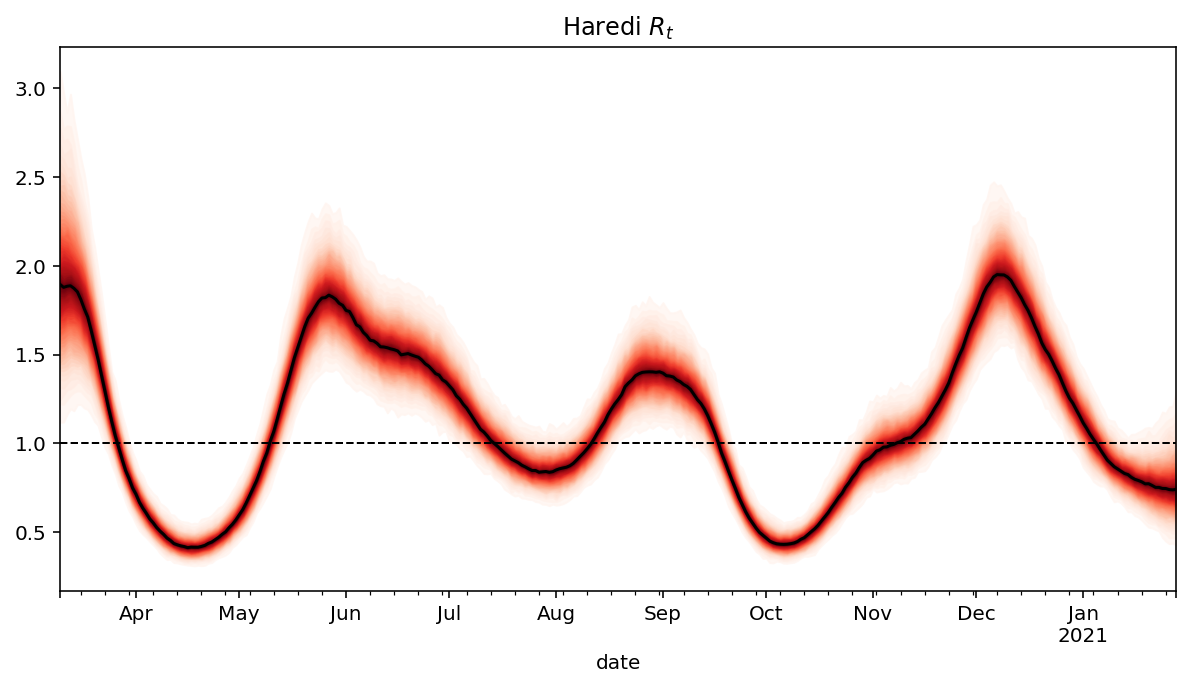

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Haredi $R_t$")
samples = gmbb.trace['r_t']
x=resultbb.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultbb["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [5]:
resultbb.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-09,1.960111,1.948113,1.689921,2.181270,119.922759,48.275501,41.0,41.0,500000
2020-12-10,1.948561,1.936758,1.714642,2.186078,138.328557,53.983585,41.0,41.0,500000
2020-12-11,1.920375,1.918198,1.695072,2.171350,159.524693,60.743243,59.0,59.0,500000
2020-12-12,1.891139,1.883512,1.639024,2.097761,183.744897,68.728711,7.0,7.0,500000
2020-12-13,1.857205,1.852005,1.628392,2.082754,211.036557,78.129552,68.0,68.0,500000
2020-12-14,1.828618,1.820185,1.553432,2.045217,241.484490,89.148854,110.0,110.0,500000
2020-12-15,1.788587,1.781498,1.544719,2.000722,275.221239,101.999935,121.0,121.0,500000
2020-12-16,1.748050,1.748203,1.512882,1.966981,312.432982,116.891143,148.0,148.0,500000
2020-12-17,1.707570,1.706372,1.462066,1.927178,353.111879,134.020005,167.0,167.0,500000


# General population

In [6]:
gn = ['5000', '8400', '8300', '1139', '2800', '9000', '2600', '6500', '6600', '6200', '9500']
model_gn = dfcit.loc[gn].groupby('date').sum()
gmgn = GenerativeModel(gn, model_gn, buffer_days = 10, delay=2, sigma=0.07)
gmgn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2366 seconds.


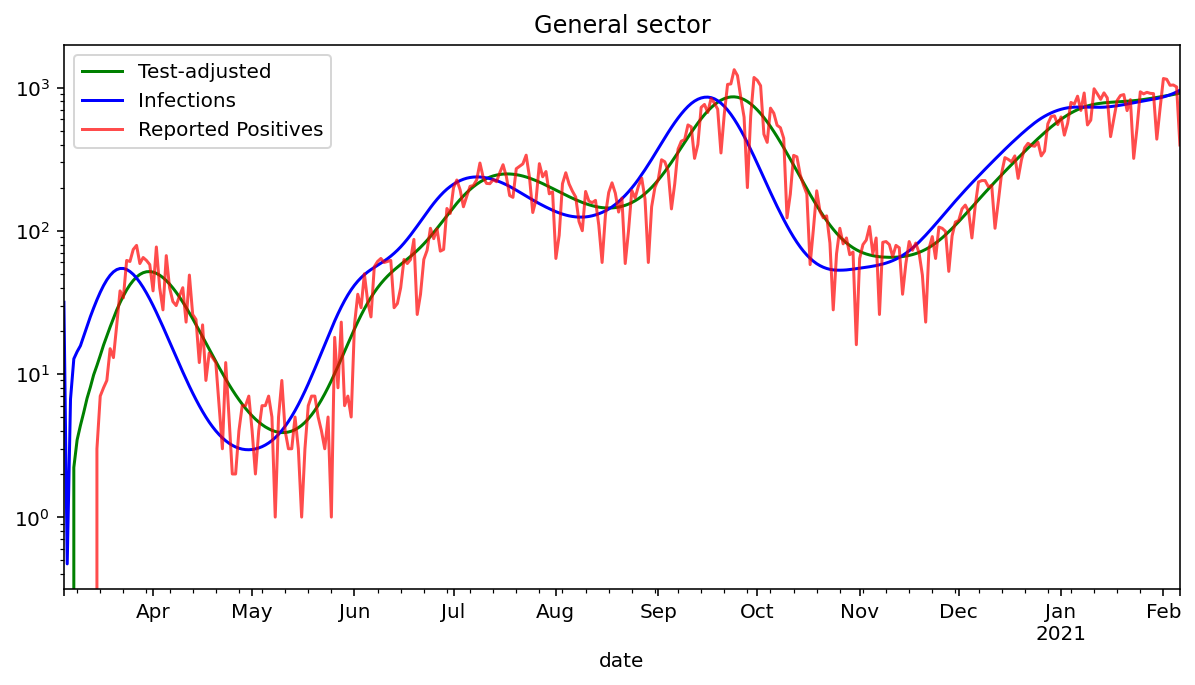

In [7]:
resultgn = summarize_inference_data(gmgn.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("General sector")
resultgn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultgn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgn.infections.plot(c="b", label="Infections")
gmgn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmgn.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

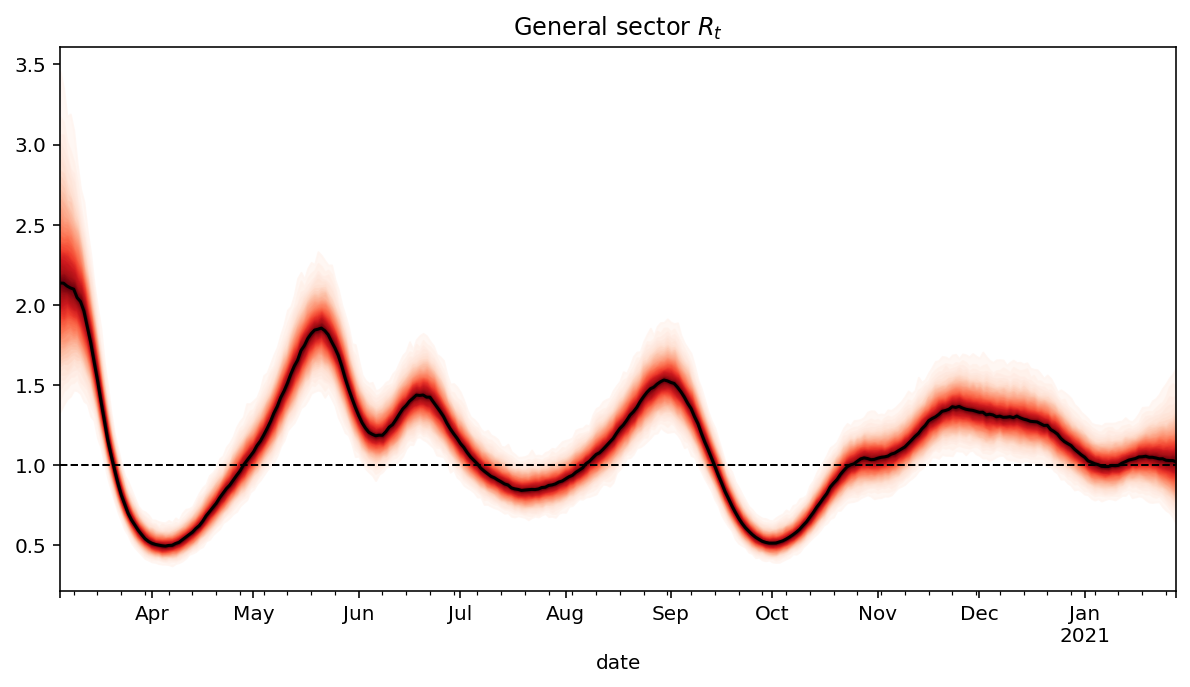

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"General sector $R_t$")
samples = gmgn.trace['r_t']
x=resultgn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultgn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [9]:
resultgn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-09,1.305359,1.297966,1.110203,1.424880,268.879691,184.881687,224.0,224.0,1100000
2020-12-10,1.306416,1.301123,1.124837,1.434857,283.946752,195.867550,203.0,203.0,1100000
2020-12-11,1.304421,1.294857,1.139799,1.462626,299.550606,207.399854,207.0,207.0,1100000
2020-12-12,1.303448,1.304997,1.120298,1.439532,315.881693,219.511067,104.0,104.0,1100000
2020-12-13,1.296255,1.294318,1.129428,1.456768,333.063516,232.230169,160.0,160.0,1100000
2020-12-14,1.294781,1.286156,1.111612,1.440249,351.109800,245.571784,252.0,252.0,1100000
2020-12-15,1.286042,1.280847,1.110564,1.435617,369.889453,259.554651,324.0,324.0,1100000
2020-12-16,1.279574,1.272543,1.111622,1.427992,389.400111,274.208987,315.0,315.0,1100000
2020-12-17,1.277252,1.270372,1.115257,1.438407,409.567615,289.570481,303.0,303.0,1100000


# Arab cities

In [10]:
ar = ['472', '2710', '6000', '2730', '2720', '8900', '509', '634', '7300', '7500', '531', '637', '638', '543', '8800']
model_ar = dfcit.loc[ar].groupby('date').sum()
gmar = GenerativeModel(ar, model_ar, buffer_days = 10, delay=2, sigma=0.07)
gmar.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1964 seconds.


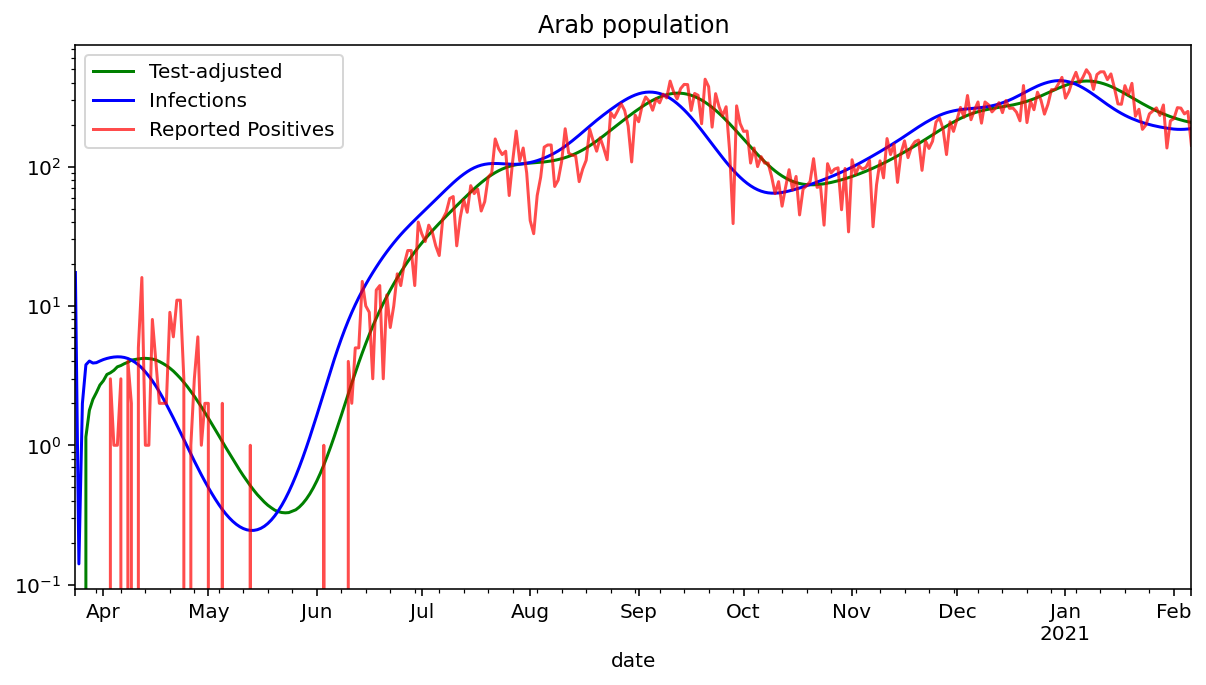

In [11]:
resultar = summarize_inference_data(gmar.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Arab population")
resultar.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultar.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultar.infections.plot(c="b", label="Infections")
gmar.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

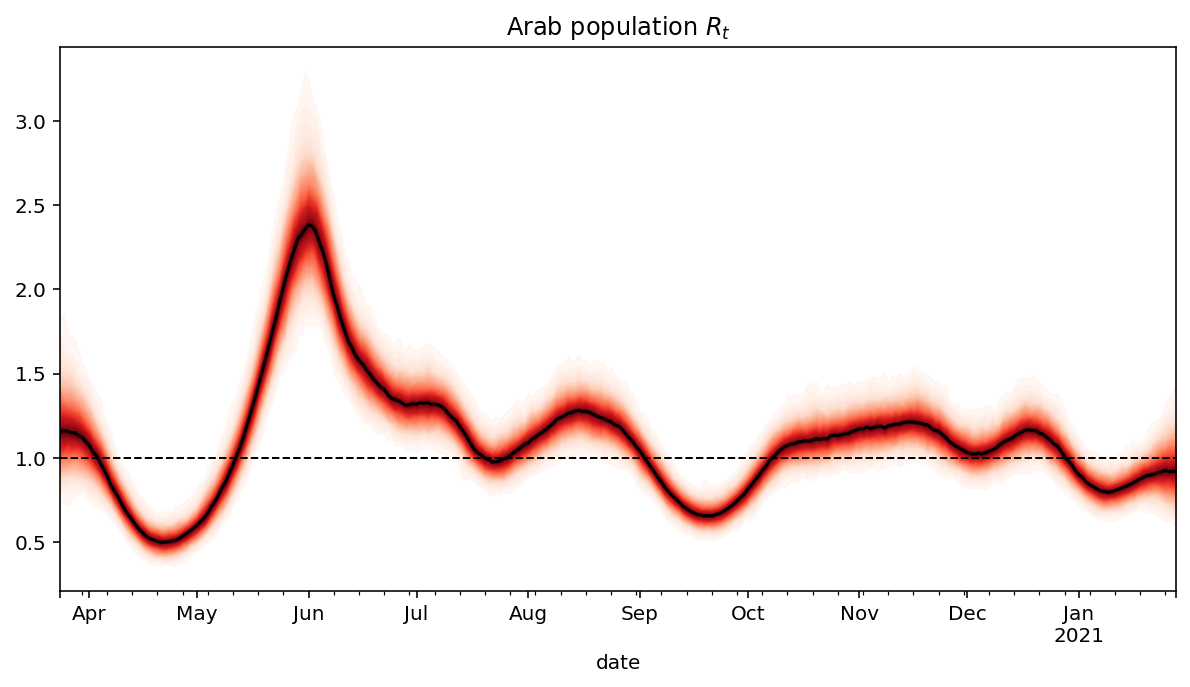

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Arab population $R_t$")
samples = gmar.trace['r_t']
x=resultar.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultar["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [13]:
resultar.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-09,1.063820,1.060584,0.951520,1.203919,267.607675,255.075554,291.0,291.0,1500000
2020-12-10,1.079876,1.077706,0.935628,1.196128,270.180719,258.189576,278.0,278.0,1500000
2020-12-11,1.096826,1.092244,0.940592,1.224035,273.278095,261.023786,247.0,247.0,1500000
2020-12-12,1.109730,1.105462,0.937213,1.220708,277.026029,263.660240,263.0,263.0,1500000
2020-12-13,1.121009,1.112937,0.973873,1.255718,281.652329,266.193370,288.0,288.0,1500000
2020-12-14,1.132741,1.125962,0.984835,1.272278,287.143863,268.718415,244.0,244.0,1500000
2020-12-15,1.147151,1.142810,0.992818,1.287370,293.394700,271.333410,298.0,298.0,1500000
2020-12-16,1.159371,1.151925,1.017850,1.315335,300.398381,274.145857,262.0,262.0,1500000
2020-12-17,1.168964,1.162526,1.026256,1.335204,308.265960,277.261400,263.0,263.0,1500000


In [14]:
jr = ['3000']
model_jr = dfcit.loc[jr].groupby('date').sum()
gmjr = GenerativeModel(jr, model_jr, buffer_days = 10, delay=2)
gmjr.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1804 seconds.


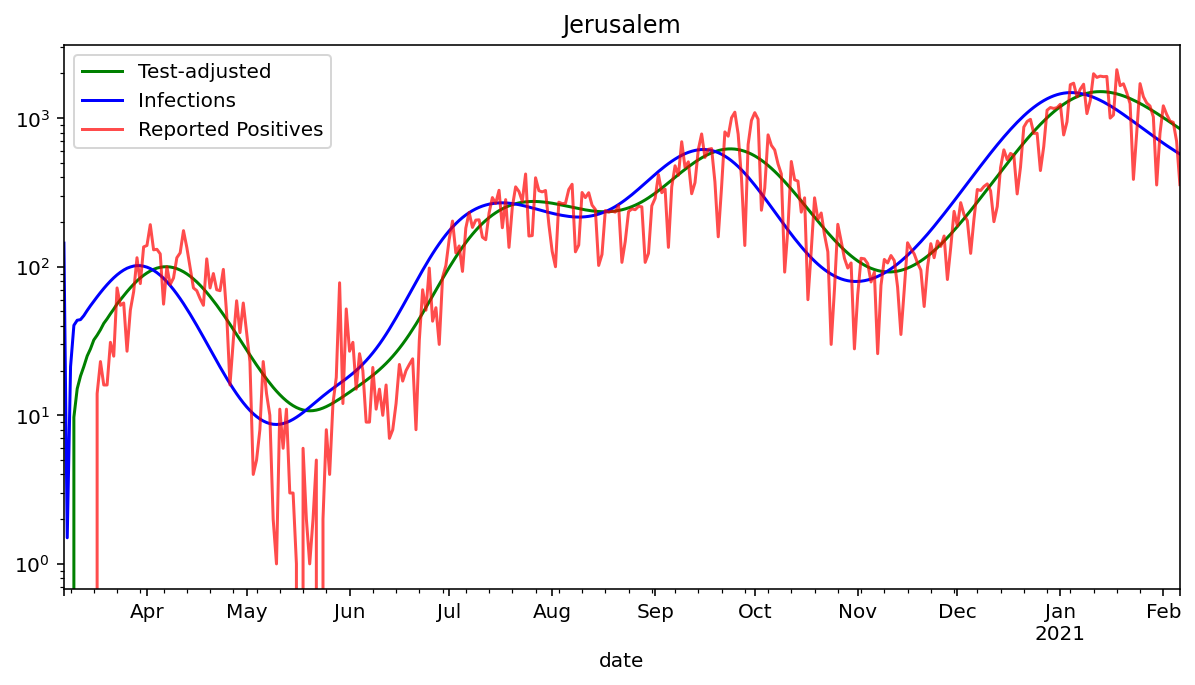

In [15]:
resultjr = summarize_inference_data(gmjr.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Jerusalem")
resultjr.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultjr.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultjr.infections.plot(c="b", label="Infections")
gmjr.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmjr.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

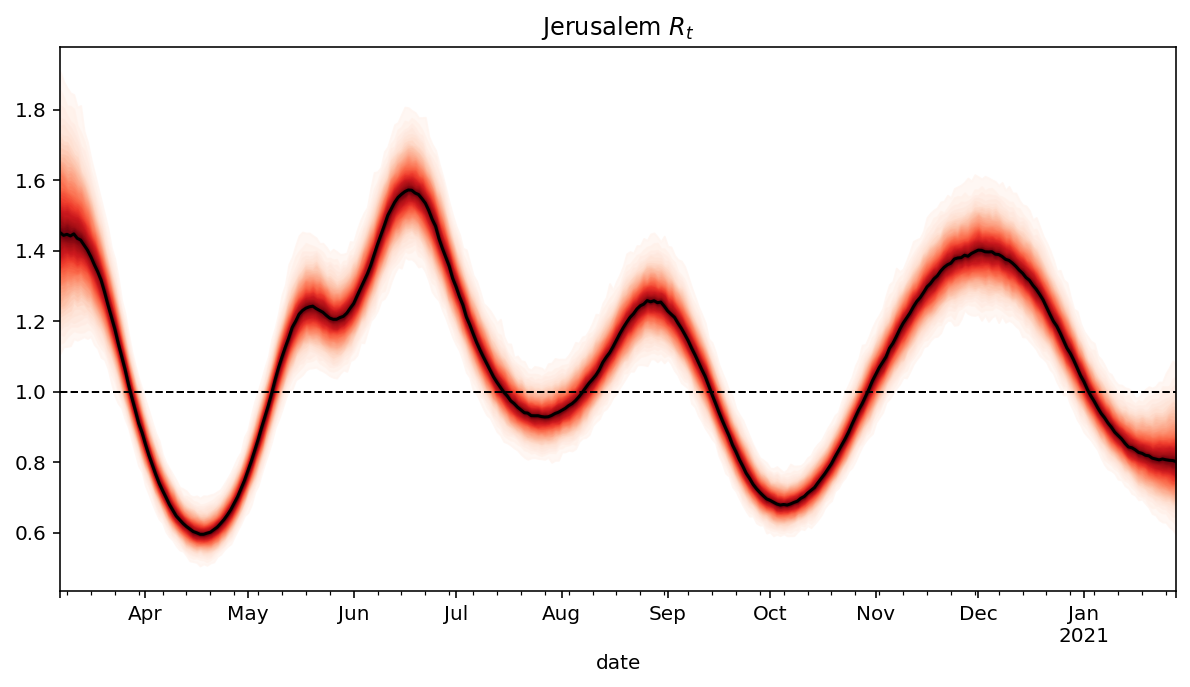

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Jerusalem $R_t$")
samples = gmjr.trace['r_t']
x=resultjr.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultjr["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [17]:
resultjr.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-09,1.376987,1.375051,1.276359,1.480048,510.232257,310.835541,347.0,347.0,100000
2020-12-10,1.373953,1.372104,1.266537,1.468921,545.260430,332.286103,361.0,361.0,100000
2020-12-11,1.365960,1.364643,1.247648,1.450459,582.015920,355.288634,324.0,324.0,100000
2020-12-12,1.357742,1.355484,1.253851,1.449752,620.691889,379.922325,201.0,201.0,100000
2020-12-13,1.347325,1.344566,1.257686,1.456707,661.357515,406.256174,254.0,254.0,100000
2020-12-14,1.339012,1.335736,1.220937,1.416742,703.799505,434.336221,465.0,465.0,100000
2020-12-15,1.327006,1.323438,1.222182,1.427701,747.815409,464.205655,612.0,612.0,100000
2020-12-16,1.317898,1.315761,1.222503,1.429101,793.361313,495.908105,525.0,525.0,100000
2020-12-17,1.303521,1.301801,1.219262,1.417154,840.292001,529.470983,579.0,579.0,100000


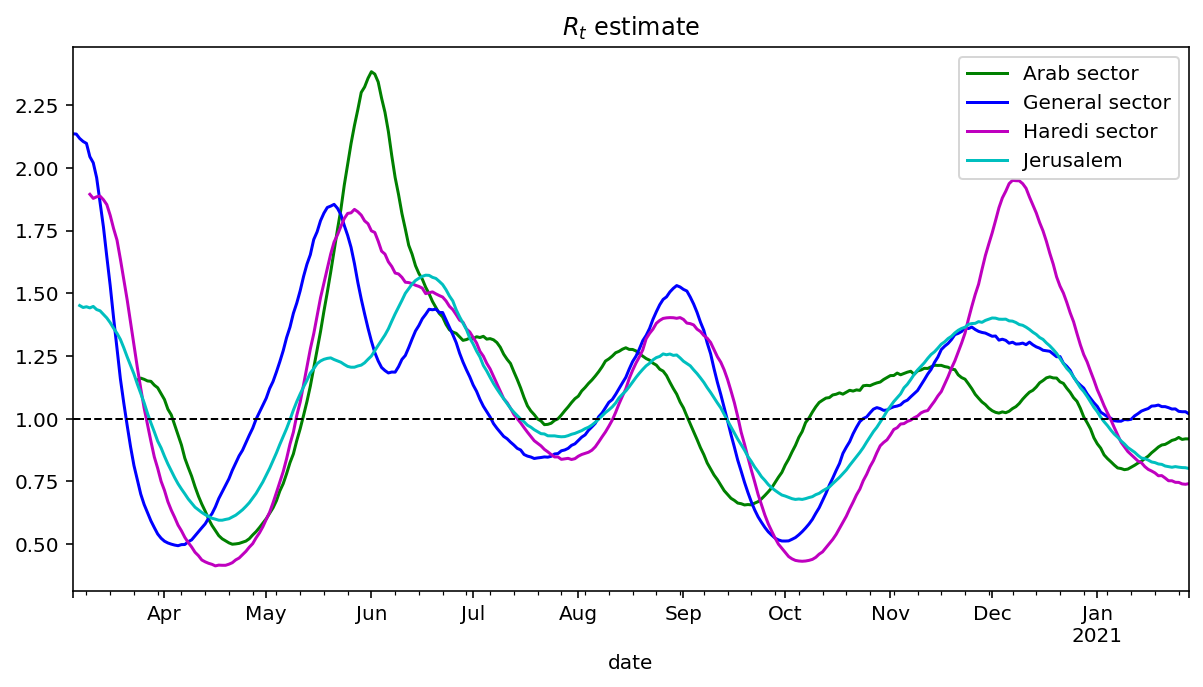

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultar["median"].plot(c="g", ls='-', label="Arab sector")
resultgn["median"].plot(c="b", ls='-', label="General sector")
resultbb["median"].plot(c="m", ls='-', label="Haredi sector")
resultjr["median"].plot(c="c", ls='-', label="Jerusalem")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [19]:
resultar.to_csv("results_arab_cities_out.csv")
resultbb.to_csv("results_haredi_cities_out.csv")
resultgn.to_csv("results_general_cities_out.csv")
resultjr.to_csv("results_jerusalem_out.csv")

{'3650', '3618', '3563', '3726', '3604', '3725'}


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1447 seconds.


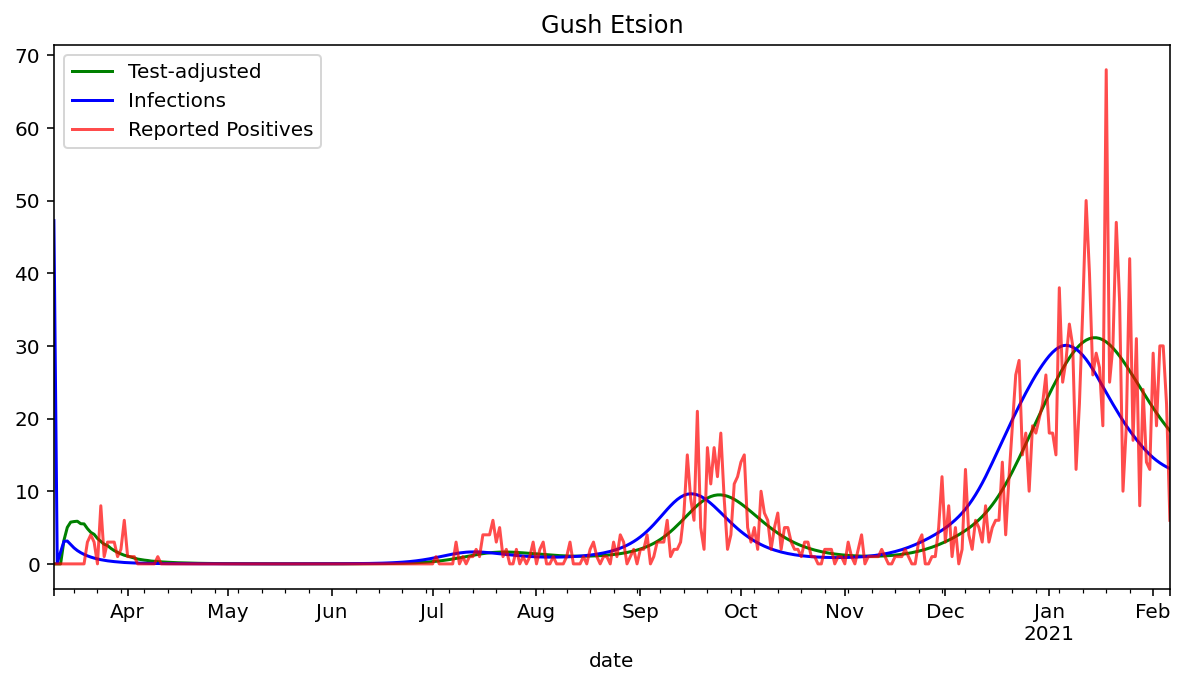

In [20]:
gush = ["3604", "3618", "3650", "3794", "3603", "3488", "3561", "3653", "3725", "3726", "1982", "1981", "3781", "3602", "3563"]
gush = set(gush) & set(list(dfcit.index.unique(0)))
print(gush)
model_gs = dfcit.loc[gush].groupby('date').sum()
gmgs = GenerativeModel(gush, model_gs, buffer_days = 10, delay=2, sigma=0.07)
gmgs.sample()

resultgs = summarize_inference_data(gmgs.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Gush Etsion")
resultgs.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgs.infections.plot(c="b", label="Infections")
gmgs.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
#plt.yscale("log")
ax.legend();

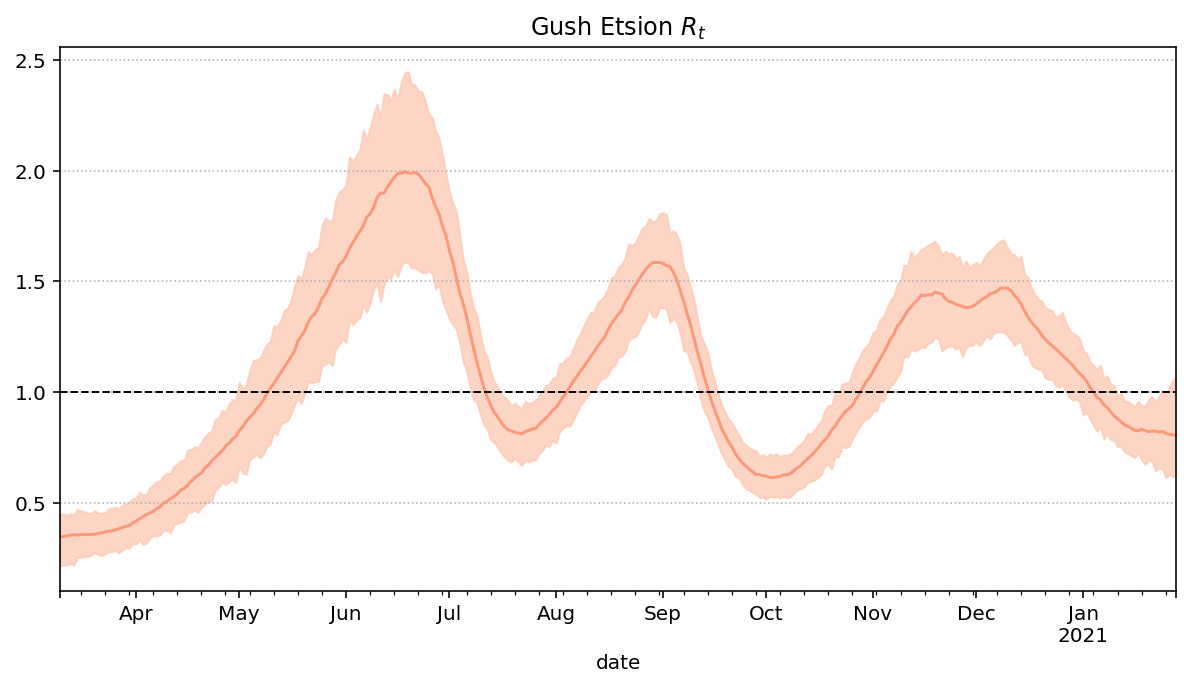

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Gush Etsion $R_t$")
samples = gmgs.trace['r_t']
x=resultgs.index
colmap = plt.get_cmap("Reds")
ax.fill_between(x, resultgs["upper_80"], resultgs["lower_80"], color=colmap(50), alpha=.8)
resultgs["median"].plot(c=colmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
